# Bank Bot! 

Scenario: Mary is a new user at Clerkie who wants to buy her dream house. She thinks she has \$200,000
saved up, but she is not sure. She wants to know if she can afford this new house in Los Angeles (which
is worth \$2.3M).
Mary logs in and is thinking of asking Clerkie 3 categories of questions (which by the way can come in
multiple forms):
- Category 1: Check Balance (e.g., "How much do I have saved up in my account ending in
(x9898)?", "How much money do I have stashed up in my Bank of America?", "What is my
current BoA savings balance?", etc)
- Category 2: Budgeting (e.g., "How much wiggle room do I have in my budget?", "How much
spare money do I have?", "How much money can I save each month?", etc)
- Category 3: House affordability (e.g., "Can I afford a \$2.3 million house?", "Can I buy a \$2.3M
crib?", etc). 

In this project, I'll start with a baseline model (BankBot-V1) using word embeddings, then build a more sophisticated model (BankBot-V2) that further incorporates an LSTM. 

Lets get started! Run the following cell to load the packages. 

In [1]:
import numpy as np
from clerkie_utils import *
import matplotlib.pyplot as plt

%matplotlib inline

## 1 - Baseline model: BankBot-V1

### 1.1 - Dataset BankBotSET

Let's start by building a simple baseline classifier. 

You have a tiny dataset (X, Y) where:
- X contains 127 sentences (strings)
- Y contains a integer label between 0 and 3 corresponding to an category for each sentence
- Cat 1: Balance, Cat 2: Budgeting, Cat 3: Home buying & Cat 0: is unknown.


<img src="images/data.png" style="width:700px;height:300px;">
<caption><center> **Figure 1**: BankBotSET - a classification problem with 4 classes. A few examples of sentences are given here. </center></caption>

Let's load the dataset using the code below. 

In [2]:
X_train, Y_train = read_csv('data/bank_data.csv')

Template data is augmented to increase training and test data

In [3]:
import re

aug_dict = {
    1: ['checking', 'savings', 'credit card', 'BoA', 'Bank of America', 'Wells Fargo', 'Chase'],
    2: ['rent', 'groceries', 'utilities', 'shopping', 'eating out', 'restaurant dining'],
    3: ['crib', 'pad', 'house', 'single family home', 'apartment', 'town house', 'condo']
}

X_data_aug = []
Y_data_aug = []
for idx, phrase in enumerate(X_train):
    phrase = phrase.replace("?", "").lower()
    if phrase.find('_') != -1:
        for word in aug_dict[Y_train[idx]]:
            X_data_aug.append(re.sub('_', word, phrase))
            Y_data_aug.append(Y_train[idx])
    else:
        X_data_aug.append(phrase)
        Y_data_aug.append(Y_train[idx])


In [4]:
for index in range(len(X_data_aug)):
    print(str(index) + ': ', X_data_aug[index], Y_data_aug[index])

0:  how much do i have saved up in my account ending in
 checking 1
1:  how much do i have saved up in my account ending in
 savings 1
2:  how much do i have saved up in my account ending in
 credit card 1
3:  how much do i have saved up in my account ending in
 BoA 1
4:  how much do i have saved up in my account ending in
 Bank of America 1
5:  how much do i have saved up in my account ending in
 Wells Fargo 1
6:  how much do i have saved up in my account ending in
 Chase 1
7:  how much money do i have stashed up in my checking 1
8:  how much money do i have stashed up in my savings 1
9:  how much money do i have stashed up in my credit card 1
10:  how much money do i have stashed up in my BoA 1
11:  how much money do i have stashed up in my Bank of America 1
12:  how much money do i have stashed up in my Wells Fargo 1
13:  how much money do i have stashed up in my Chase 1
14:  what is my
 current checking  balance 1
15:  what is my
 current savings  balance 1
16:  what is my
 current

In [5]:
maxLen = len(max(X_train, key=len).split())
print(maxLen)

15


Run the following cell to print sentences from X_train and corresponding labels from Y_train. Change `index` to see different examples.

In [6]:
index = 1
print(X_data_aug[index], Y_data_aug[index])

how much do i have saved up in my account ending in
 savings 1


Split the dataset between training and testing.

In [7]:
from sklearn.model_selection import train_test_split
X_train_aug, X_test_aug, y_train_aug, y_test_aug = train_test_split(X_data_aug, Y_data_aug, test_size=0.25, random_state=42)
print("training set size ", len(X_train_aug))
print("Test set size ",  len(X_test_aug))

training set size  299
Test set size  100


### 1.2 - Overview of the BankBot-V1

Implement a baseline model called "BankBot-v1".  

<center>
<img src="images/BankBotV1.png" style="width:900px;height:300px;">
<caption><center> **Figure 2**: Baseline model (BankBot-V1).</center></caption>
</center>

The input of the model is a string corresponding to a sentence (e.g. "I love you). In the code, the output will be a probability vector of shape (1,4), that you then pass in an argmax layer to extract the index of the most likely category output.

To get our labels into a format suitable for training a softmax classifier, lets convert $Y$ from its current shape  current shape $(m, 1)$ into a "one-hot representation" $(m, 4)$, where each row is a one-hot vector giving the label of one example, You can do so using this next code snipper. Here, `y_oh` stands for "y-one-hot" in the variable names `y_oh_train` and `y_oh_test`: 


In [8]:
y_oh_train = convert_to_one_hot(np.array(y_train_aug), C = 4)

Let's see what `convert_to_one_hot()` did. Feel free to change `index` to print out different values. 

In [9]:
index = 50
print(y_train_aug[index], "is converted into one hot", y_oh_train[index])

1 is converted into one hot [0. 1. 0. 0.]


All the data is now ready to be fed into the BankBot-V1 model. Let's implement the model!

### 1.3 - Implementing BankBot-V1

As shown in Figure (2), the first step is to convert an input sentence into the word vector representation, which then get averaged together. Similar to the previous exercise, we will use pretrained 50-dimensional GloVe embeddings. Run the following cell to load the `word_to_vec_map`, which contains all the vector representations.

In [10]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('data/glove.6B.50d_v2.txt')

You've loaded:
- `word_to_index`: dictionary mapping from words to their indices in the vocabulary (400,001 words, with the valid indices ranging from 0 to 400,000)
- `index_to_word`: dictionary mapping from indices to their corresponding words in the vocabulary
- `word_to_vec_map`: dictionary mapping words to their GloVe vector representation.

Run the following cell to check if it works.

In [11]:
word = "cucumber"
index = 289846
print("the index of", word, "in the vocabulary is", word_to_index[word])
print("the", str(index) + "th word in the vocabulary is", index_to_word[index])

the index of cucumber in the vocabulary is 113317
the 289846th word in the vocabulary is potatos


`sentence_to_avg()`. You will need to carry out two steps:
1. Convert every sentence to lower-case, then split the sentence into a list of words. `X.lower()` and `X.split()` might be useful. 
2. For each word in the sentence, access its GloVe representation. Then, average all these values.

In [12]:
def sentence_to_avg(sentence, word_to_vec_map):
    """
    Converts a sentence (string) into a list of words (strings). Extracts the GloVe representation of each word
    and averages its value into a single vector encoding the meaning of the sentence.
    
    Arguments:
    sentence -- string, one training example from X
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    
    Returns:
    avg -- average vector encoding information about the sentence, numpy-array of shape (50,)
    """
    
    ### START CODE HERE ###
    # Step 1: Split sentence into list of lower case words (≈ 1 line)
    words = [word.lower() for word in sentence.split()]

    # Initialize the average word vector, should have the same shape as your word vectors.
    avg = np.zeros((50,))
    
    # Step 2: average the word vectors. You can loop over the words in the list "words".
    for w in words:
        try:
            avg += word_to_vec_map[w]
        except:
            pass
    avg = avg/len(words)
    
    return avg

In [13]:
avg = sentence_to_avg("Morrocan couscous is my favorite dish", word_to_vec_map)
print("avg = ", avg)

avg =  [-0.008005    0.56370833 -0.50427333  0.258865    0.55131103  0.03104983
 -0.21013718  0.16893933 -0.09590267  0.141784   -0.15708967  0.18525867
  0.6495785   0.38371117  0.21102167  0.11301667  0.02613967  0.26037767
  0.05820667 -0.01578167 -0.12078833 -0.02471267  0.4128455   0.5152061
  0.38756167 -0.898661   -0.535145    0.33501167  0.68806933 -0.2156265
  1.797155    0.10476933 -0.36775333  0.750785    0.10282583  0.348925
 -0.27262833  0.66768    -0.10706167 -0.283635    0.59580117  0.28747333
 -0.3366635   0.23393817  0.34349183  0.178405    0.1166155  -0.076433
  0.1445417   0.09808667]


**Expected Output**:

<table>
    <tr>
        <td>
            **avg= **
        </td>
        <td>
           [-0.008005    0.56370833 -0.50427333  0.258865    0.55131103  0.03104983
 -0.21013718  0.16893933 -0.09590267  0.141784   -0.15708967  0.18525867
  0.6495785   0.38371117  0.21102167  0.11301667  0.02613967  0.26037767
  0.05820667 -0.01578167 -0.12078833 -0.02471267  0.4128455   0.5152061
  0.38756167 -0.898661   -0.535145    0.33501167  0.68806933 -0.2156265
  1.797155    0.10476933 -0.36775333  0.750785    0.10282583  0.348925
 -0.27262833  0.66768    -0.10706167 -0.283635    0.59580117  0.28747333
 -0.3366635   0.23393817  0.34349183  0.178405    0.1166155  -0.076433
  0.1445417   0.09808667]
        </td>
    </tr>
</table>

#### Model

All the pieces now ready to finish implementing the `model()` function. After using `sentence_to_avg()` need to pass the average through forward propagation, compute the cost, and then backpropagate to update the softmax's parameters. 

`model()` function described in Figure (2). Assuming here that $Yoh$ ("Y one hot") is the one-hot encoding of the output labels, the equations need to implement in the forward pass and to compute the cross-entropy cost are:
$$ z^{(i)} = W . avg^{(i)} + b$$
$$ a^{(i)} = softmax(z^{(i)})$$
$$ \mathcal{L}^{(i)} = - \sum_{k = 0}^{n_y - 1} Yoh^{(i)}_k * log(a^{(i)}_k)$$

It is possible to come up with a more efficient vectorized implementation. But since we are using a for-loop to convert the sentences one at a time into the avg^{(i)} representation anyway, let's not bother this time. 


In [14]:
# GRADED FUNCTION: model

def model(X, Y, word_to_vec_map, learning_rate = 0.01, num_iterations = 400):
    """
    Model to train word vector representations in numpy.
    
    Arguments:
    X -- input data, numpy array of sentences as strings, of shape (m, 1)
    Y -- labels, numpy array of integers between 0 and 7, numpy-array of shape (m, 1)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    learning_rate -- learning_rate for the stochastic gradient descent algorithm
    num_iterations -- number of iterations
    
    Returns:
    pred -- vector of predictions, numpy-array of shape (m, 1)
    W -- weight matrix of the softmax layer, of shape (n_y, n_h)
    b -- bias of the softmax layer, of shape (n_y,)
    """
    
    np.random.seed(1)

    # Define number of training examples
    m = Y.shape[0]                          # number of training examples
    n_y = 5                                 # number of classes  
    n_h = 50                                # dimensions of the GloVe vectors 
    
    # Initialize parameters using Xavier initialization
    W = np.random.randn(n_y, n_h) / np.sqrt(n_h)
    b = np.zeros((n_y,))
    
    # Convert Y to Y_onehot with n_y classes
    Y_oh = convert_to_one_hot(Y, C = n_y) 
    
    # Optimization loop
    for t in range(num_iterations):                       # Loop over the number of iterations
        for i in range(m):                                # Loop over the training examples
            
            ### START CODE HERE ### (≈ 4 lines of code)
            # Average the word vectors of the words from the i'th training example
            avg = sentence_to_avg(X[i], word_to_vec_map)

            # Forward propagate the avg through the softmax layer
            z = np.dot(W, avg)+b
            a = softmax(z)

            # Compute cost using the i'th training label's one hot representation and "A" (the output of the softmax)
            cost = -np.sum(Y_oh[i]*np.log(a))
            ### END CODE HERE ###
            
            # Compute gradients 
            dz = a - Y_oh[i]
            dW = np.dot(dz.reshape(n_y,1), avg.reshape(1, n_h))
            db = dz

            # Update parameters with Stochastic Gradient Descent
            W = W - learning_rate * dW
            b = b - learning_rate * db
        
        if t % 100 == 0:
            print("Epoch: " + str(t) + " --- cost = " + str(cost))
            pred = predict(X, Y, W, b, word_to_vec_map)

    return pred, W, b

Run the next cell to train your model and learn the softmax parameters (W,b). 

In [15]:
import string
for idx, line in enumerate(X_train_aug):
    X_data_aug[idx] = line.translate(string.punctuation).lower()
    print(X_data_aug[idx])

are single family home sales high or low
am i in the black on bank of america account
what is my+ current credit card  balance
how many bucks do i have in credit card
what is taken out of my account for groceries each month
how much money do i have stashed up in my checking
what is my+ current wells fargo  balance
what do i spend on restaurant dining each month
i adore my dogs
can i buy a $2m bugatti
how much do i earn a month
how many dollars do i keep at the end of the month
good joke
stop shouting at me
let us go play baseball
boa balance
what is the balance left in savings account
when is the best time to buy a apartment
i never said yes for this
how much is the tax on a town house
what is taken out of my account for restaurant dining each month
am i in the black on boa account
what is my+ current boa  balance
what expenses do i need to consider when buying a apartment
how much money do i have left in my boa
your stupidity has no limit
i will celebrate soon
you did well on you exam

In [16]:
pred, W, b = model(np.array(X_train_aug), np.array(y_train_aug), word_to_vec_map)
print(pred)

Epoch: 0 --- cost = nan
Accuracy: 0.2809364548494983


C:\Users\hayesmat\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
C:\Users\hayesmat\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
C:\Users\hayesmat\Desktop\deep_learning\Emojify\clerkie_utils.py:99: RuntimeWarning: invalid value encountered in true_divide
  avg = avg/len(words)


Epoch: 100 --- cost = nan
Accuracy: 0.2809364548494983
Epoch: 200 --- cost = nan
Accuracy: 0.2809364548494983
Epoch: 300 --- cost = nan
Accuracy: 0.2809364548494983
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 

**Expected Output** (on a subset of iterations):

<table>
    <tr>
        <td>
            **Epoch: 0**
        </td>
        <td>
           cost = 0.6996919680186912
        </td>
        <td>
           Accuracy: 0.5627906976744186
        </td>
    </tr>


<tr>
        <td>
            **Epoch: 100**
        </td>
        <td>
           cost = 0.21915961790021646
        </td>
        <td>
           Accuracy: 0.958139534883721
        </td>
    </tr>
    
<tr>
        <td>
            **Epoch: 200**
        </td>
        <td>
           cost = 0.11877416714551443
        </td>
        <td>
           Accuracy: 0.9674418604651163
        </td>
    </tr>
    
    <tr>
        <td>
            **Epoch: 300**
        </td>
        <td>
           cost = 0.07981120520808174
        </td>
        <td>
           Accuracy: 0.9720930232558139
        </td>
    </tr>
</table>

Great! Model has pretty high accuracy on the training set. How it does on the test set?

### 1.4 - Examining test set performance 


In [17]:
print("Training set:")
pred_train = predict(np.array(X_train_aug), np.array(y_train_aug), W, b, word_to_vec_map)
print('Test set:')
pred_test = predict(np.array(X_test_aug), np.array(y_test_aug), W, b, word_to_vec_map)

Training set:
Accuracy: 0.2809364548494983
Test set:
Accuracy: 0.28


C:\Users\hayesmat\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
C:\Users\hayesmat\Desktop\deep_learning\Emojify\clerkie_utils.py:99: RuntimeWarning: invalid value encountered in true_divide
  avg = avg/len(words)


**Expected Output**:

<table>
    <tr>
        <td>
            **Train set accuracy**
        </td>
        <td>
           28.1
        </td>
    </tr>
    <tr>
        <td>
            **Test set accuracy**
        </td>
        <td>
           28.0
        </td>
    </tr>
</table>

Random guessing would have had 25% accuracy given that there are 4 classes. This is pretty bad performance after training on only a few hundred examples. 

In [18]:
X_my_sentences = np.array(["How much is in my BoA checking?", "How much money do I have left at month end", "Can I afford a car"])
Y_my_labels = np.array([[1], [2], [3]])

pred = predict(X_my_sentences, Y_my_labels , W, b, word_to_vec_map)
print(pred)

Accuracy: 0.0
[[0.]
 [0.]
 [0.]]


C:\Users\hayesmat\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


Printing the confusion matrix can also help understand which classes are more difficult for your model. A confusion matrix shows how often an example whose label is one class ("actual" class) is mislabeled by the algorithm with a different class ("predicted" class). 




(100,)
Predicted  0.0  All
Actual             
0           28   28
1           40   40
2           12   12
3           20   20
All        100  100


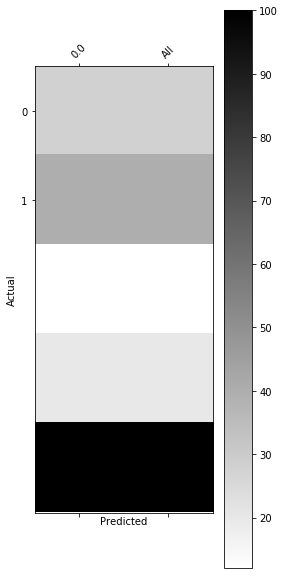

In [19]:
print(np.array(y_test_aug).shape)
print(pd.crosstab(np.array(y_test_aug), pred_test.reshape(100,), rownames=['Actual'], colnames=['Predicted'], margins=True))
plot_confusion_matrix(np.array(y_test_aug), pred_test)

## 2 - BankBot-V2: Using LSTMs in Keras: 

LSTM model that takes as input word sequences. This model will be able to take word ordering into account. BankBot-V2 will continue to use pre-trained word embeddings to represent words, but will feed them into an LSTM, whose job it is to predict the most appropriate category. 

Run the following cell to load the Keras packages.

In [20]:
import numpy as np
np.random.seed(0)
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform
np.random.seed(1)

Using TensorFlow backend.


### 2.1 - Overview of the model

BankBot-v2 architecture:

<img src="images/emojifier-v2.png" style="width:700px;height:400px;"> <br>
<caption><center> **Figure 3**: BankBot-V2. A 2-layer LSTM sequence classifier. </center></caption>



### 2.2 Keras and mini-batching 

Want to train Keras using mini-batches. However, most deep learning frameworks require that all sequences in the same mini-batch have the same length. This is what allows vectorization to work: If you had a 3-word sentence and a 4-word sentence, then the computations needed for them are different (one takes 3 steps of an LSTM, one takes 4 steps) so it's just not possible to do them both at the same time.

The common solution to this is to use padding. Specifically, set a maximum sequence length, and pad all sequences to the same length. For example, of the maximum sequence length is 20, we could pad every sentence with "0"s so that each input sentence is of length 20. Thus, a sentence "i love you" would be represented as $(e_{i}, e_{love}, e_{you}, \vec{0}, \vec{0}, \ldots, \vec{0})$. In this example, any sentences longer than 20 words would have to be truncated. One simple way to choose the maximum sequence length is to just pick the length of the longest sentence in the training set. 


### 2.3 - The Embedding layer

In Keras, the embedding matrix is represented as a "layer", and maps positive integers (indices corresponding to words) into dense vectors of fixed size (the embedding vectors). It can be trained or initialized with a pretrained embedding. In this part, you will learn how to create an [Embedding()](https://keras.io/layers/embeddings/) layer in Keras, initialize it with the GloVe 50-dimensional vectors loaded earlier in the notebook. Because our training set is quite small, we will not update the word embeddings but will instead leave their values fixed. But in the code below, we'll show you how Keras allows you to either train or leave fixed this layer.  

The `Embedding()` layer takes an integer matrix of size (batch size, max input length) as input. This corresponds to sentences converted into lists of indices (integers), as shown in the figure below.

<img src="images/embedding1.png" style="width:700px;height:250px;">
<caption><center> **Figure 4**: Embedding layer. This example shows the propagation of two examples through the embedding layer. Both have been zero-padded to a length of `max_len=5`. The final dimension of the representation is  `(2,max_len,50)` because the word embeddings we are using are 50 dimensional. </center></caption>

The largest integer (i.e. word index) in the input should be no larger than the vocabulary size. The layer outputs an array of shape (batch size, max input length, dimension of word vectors).

The first step is to convert all your training sentences into lists of indices, and then zero-pad all these lists so that their length is the length of the longest sentence. 

The function below to convert X (array of sentences as strings) into an array of indices corresponding to words in the sentences. The output shape should be such that it can be given to `Embedding()` (described in Figure 4). 

In [21]:
def sentences_to_indices(X, word_to_index, max_len):
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    The output shape should be such that it can be given to `Embedding()` (described in Figure 4). 
    
    Arguments:
    X -- array of sentences (strings), of shape (m, 1)
    word_to_index -- a dictionary containing the each word mapped to its index
    max_len -- maximum number of words in a sentence. You can assume every sentence in X is no longer than this. 
    
    Returns:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    """
    
    m = X.shape[0]                                   # number of training examples
    
    # Initialize X_indices as a numpy matrix of zeros and the correct shape (≈ 1 line)
    X_indices = np.zeros((m,max_len))
    
    for i in range(m):                               # loop over training examples
        
        # Convert the ith training sentence in lower case and split is into words. You should get a list of words.
        sentence_words =[word.lower() for word in X[i].split()]
        
        # Initialize j to 0
        j = 0
        
        # Loop over the words of sentence_words
        for w in sentence_words:
            # Set the (i,j)th entry of X_indices to the index of the correct word.
            try:
                X_indices[i, j] = word_to_index[w]
                # Increment j to j + 1
                j = j+1
            except:
                pass
            
    
    return X_indices

Run the following cell to check what `sentences_to_indices()` does, and check your results.

In [22]:
X1 = np.array(["funny lol", "lets play baseball", "food is ready for you"])
X1_indices = sentences_to_indices(X1,word_to_index, max_len = 5)
print("X1 =", X1)
print("X1_indices =", X1_indices)

X1 = ['funny lol' 'lets play baseball' 'food is ready for you']
X1_indices = [[155345. 225122.      0.      0.      0.]
 [220930. 286375.  69714.      0.      0.]
 [151204. 192973. 302254. 151349. 394475.]]


**Expected Output**:

<table>
    <tr>
        <td>
            **X1 =**
        </td>
        <td>
           ['funny lol' 'lets play football' 'food is ready for you']
        </td>
    </tr>
    <tr>
        <td>
            **X1_indices =**
        </td>
        <td>
           [[ 155345.  225122.       0.       0.       0.] <br>
            [ 220930.  286375.  151266.       0.       0.] <br>
            [ 151204.  192973.  302254.  151349.  394475.]]
        </td>
    </tr>
</table>

Let's build the `Embedding()` layer in Keras, using pre-trained word vectors. After this layer is built, you will pass the output of `sentences_to_indices()` to it as an input, and the `Embedding()` layer will return the word embeddings for a sentence. 

**Exercise**: Implement `pretrained_embedding_layer()`. You will need to carry out the following steps:
1. Initialize the embedding matrix as a numpy array of zeroes with the correct shape.
2. Fill in the embedding matrix with all the word embeddings extracted from `word_to_vec_map`.
3. Define Keras embedding layer. Use [Embedding()](https://keras.io/layers/embeddings/). Be sure to make this layer non-trainable, by setting `trainable = False` when calling `Embedding()`. If you were to set `trainable = True`, then it will allow the optimization algorithm to modify the values of the word embeddings. 
4. Set the embedding weights to be equal to the embedding matrix 

In [23]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    
    vocab_len = len(word_to_index) + 1                  # adding 1 to fit Keras embedding (requirement)
    emb_dim = word_to_vec_map["cucumber"].shape[0]      # define dimensionality of your GloVe word vectors (= 50)
    
    ### START CODE HERE ###
    # Initialize the embedding matrix as a numpy array of zeros of shape (vocab_len, dimensions of word vectors = emb_dim)
    emb_matrix = np.zeros((vocab_len,emb_dim))
    
    # Set each row "index" of the embedding matrix to be the word vector representation of the "index"th word of the vocabulary
    for word, index in word_to_index.items():
        emb_matrix[index, :] = word_to_vec_map[word]

    # Define Keras embedding layer with the correct output/input sizes, make it trainable. Use Embedding(...). Make sure to set trainable=False. 
    embedding_layer = Embedding(vocab_len, emb_dim, trainable=False)
    ### END CODE HERE ###

    # Build the embedding layer, it is required before setting the weights of the embedding layer. Do not modify the "None".
    embedding_layer.build((None,))
    
    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [24]:
embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
print("weights[0][1][3] =", embedding_layer.get_weights()[0][1][3])

weights[0][1][3] = -0.3403


**Expected Output**:

<table>
    <tr>
        <td>
            **weights[0][1][3] =**
        </td>
        <td>
           -0.3403
        </td>
    </tr>
</table>

## 2.3 Building the BankBot-V2

Build the Emojifier-V2 model using the embedding layer and feed its output to an LSTM network. 

<img src="images/emojifier-v2.png" style="width:700px;height:400px;"> <br>
<caption><center> **Figure 3**: BankBot-v2. A 2-layer LSTM sequence classifier. </center></caption>


**`BankBot_V2()`**, which builds a Keras graph of the architecture shown in Figure 3. The model takes as input an array of sentences of shape (`m`, `max_len`, ) defined by `input_shape`. It should output a softmax probability vector of shape (`m`, `C = 4`). You may need `Input(shape = ..., dtype = '...')`, [LSTM()](https://keras.io/layers/recurrent/#lstm), [Dropout()](https://keras.io/layers/core/#dropout), [Dense()](https://keras.io/layers/core/#dense), and [Activation()](https://keras.io/activations/).

In [25]:
def BankBot_V2(input_shape, word_to_vec_map, word_to_index):
    """
    Function creating the BankBot-v2 model's graph.
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras
    """
    
    ### START CODE HERE ###
    # Define sentence_indices as the input of the graph, it should be of shape input_shape and dtype 'int32' (as it contains indices).
    sentence_indices =  Input(shape = input_shape, dtype = 'int32')
    
    # Create the embedding layer pretrained with GloVe Vectors (≈1 line)
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    
    # Propagate sentence_indices through your embedding layer, you get back the embeddings
    embeddings = embedding_layer(sentence_indices)   
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # Be careful, the returned output should be a batch of sequences.
    X = LSTM(128, return_sequences=True)(embeddings)
    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X)
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # Be careful, the returned output should be a single hidden state, not a batch of sequences.
    X = LSTM(128)(X)
    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X)
    # Propagate X through a Dense layer with softmax activation to get back a batch of 5-dimensional vectors.
    X = Dense(4)(X)
    # Add a softmax activation
    X = Activation('softmax')(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=sentence_indices, outputs=X)
    
    return model

Run the following cell to create the model and check its summary. Because all sentences in the dataset are less than 10 words, we chose `max_len = 10`.  You should see your architecture, it uses "20,223,927" parameters, of which 20,000,050 (the word embeddings) are non-trainable, and the remaining 223,877 are. Because our vocabulary size has 400,001 words (with valid indices from 0 to 400,000) there are 400,001\*50 = 20,000,050 non-trainable parameters. 

In [26]:
model = BankBot_V2((maxLen,), word_to_vec_map, word_to_index)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 15)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 15, 50)            20000050  
_________________________________________________________________
lstm_1 (LSTM)                (None, 15, 128)           91648     
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 516       
__________

As usual, after creating your model in Keras, you need to compile it and define what loss, optimizer and metrics your are want to use. Compile your model using `categorical_crossentropy` loss, `adam` optimizer and `['accuracy']` metrics:

In [27]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Time to train model - BankBot-V2 `model` takes as input an array of shape (`m`, `max_len`) and outputs probability vectors of shape (`m`, `number of classes`). We thus have to convert X_train (array of sentences as strings) to X_train_indices (array of sentences as list of word indices), and Y_train (labels as indices) to Y_train_oh (labels as one-hot vectors).

In [28]:
X_train_indices = sentences_to_indices(np.array(X_train_aug), word_to_index, maxLen)
Y_train_oh = convert_to_one_hot(np.array(y_train_aug), C = 4)

Fit the Keras model on `X_train_indices` and `Y_train_oh`. We will use `epochs = 50` and `batch_size = 32`.

In [29]:
model.fit(X_train_indices, Y_train_oh, epochs = 50, batch_size = 32, shuffle=True)

Epoch 1/50
299/299 [==============================] - 2s 6ms/step - loss: 1.3012 - acc: 0.3679
Epoch 2/50
299/299 [==============================] - 1s 2ms/step - loss: 1.0056 - acc: 0.7759
Epoch 3/50
299/299 [==============================] - 0s 2ms/step - loss: 0.5205 - acc: 0.8161
Epoch 4/50
299/299 [==============================] - 0s 2ms/step - loss: 0.2666 - acc: 0.9164
Epoch 5/50
299/299 [==============================] - 0s 2ms/step - loss: 0.3061 - acc: 0.9030
Epoch 6/50
299/299 [==============================] - 0s 2ms/step - loss: 0.1065 - acc: 0.9732
Epoch 7/50
299/299 [==============================] - 0s 2ms/step - loss: 0.0774 - acc: 0.9866
Epoch 8/50
299/299 [==============================] - 1s 2ms/step - loss: 0.0580 - acc: 0.9866
Epoch 9/50
299/299 [==============================] - 1s 2ms/step - loss: 0.0449 - acc: 0.9799
Epoch 10/50
299/299 [==============================] - 0s 2ms/step - loss: 0.0214 - acc: 0.9967
Epoch 11/50
299/299 [============================

The model should perform close to **100% accuracy** on the training set. The exact accuracy you get may be a little different. Run the following cell to evaluate the model on the test set. 

In [30]:
X_test_indices = sentences_to_indices(np.array(X_test_aug), word_to_index, max_len = maxLen)
Y_test_oh = convert_to_one_hot(np.array(y_test_aug), C = 4)
loss, acc = model.evaluate(X_test_indices, Y_test_oh)
print()
print("Test accuracy = ", acc)

100/100 [==============================] - 0s 3ms/step

Test accuracy =  0.95


You should get a test accuracy greater than 95%. Run the cell below to see the mislabelled examples. 

In [31]:
# This code allows you to see the mislabelled examples
C = 4
y_test_oh = np.eye(C)[np.array(y_test_aug).reshape(-1)]
X_test_indices = sentences_to_indices(np.array(X_test_aug), word_to_index, maxLen)
pred = model.predict(X_test_indices)
for i in range(len(X_test_aug)):
    x = X_test_indices
    num = np.argmax(pred[i])
    if(num != y_test_aug[i]):
        print('Expected category:'+ str(y_test_aug[i]) + ' prediction: '+ X_test_aug[i] + ' ' + str(num))

Expected category:0 prediction: are you down for baseball this afternoon 2
Expected category:0 prediction: lets have food together 2
Expected category:2 prediction: can you help me make a budget 0
Expected category:2 prediction: does my income cover my expenses 1
Expected category:0 prediction: it is the worst day in my life 2


Printing the confusion matrix can also help understand which classes are more difficult for your model. A confusion matrix shows how often an example whose label is one class ("actual" class) is mislabeled by the algorithm with a different class ("predicted" class). 


(100,)
Predicted   0   1   2   3  All
Actual                        
0          25   0   3   0   28
1           0  40   0   0   40
2           1   1  10   0   12
3           0   0   0  20   20
All        26  41  13  20  100


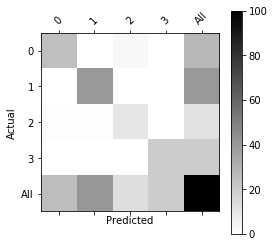

In [32]:
print(np.array(y_test_aug).shape)
pred_test = np.argmax(pred,1) 
print(pd.crosstab(np.array(y_test_aug), pred_test.reshape(100,), rownames=['Actual'], colnames=['Predicted'], margins=True))
plot_confusion_matrix(np.array(y_test_aug), pred_test)

Now you can try it on your own example. Write your own sentence below. 

In [34]:
# Change the sentence below to see your prediction. Make sure all the words are in the Glove embeddings.  
x_test = np.array(['Can I afford a $2.3M yaught?'])
X_test_indices = sentences_to_indices(x_test, word_to_index, maxLen)
print(x_test[0] +' '+  str(np.argmax(model.predict(X_test_indices))))

Can I afford a $2.3M yaught? 0


Save model for use in application

In [36]:
from keras.models import model_from_yaml
import os

# serialize model to YAML
model_yaml = model.to_yaml()
with open("model/model_v1.0.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)

# serialize weights to HDF5
model.save_weights("model/model_v1.0.h5")
print("Saved model to disk")

Saved model to disk
